<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-statement" data-toc-modified-id="Problem-statement-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem statement</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Process-data-for-ML" data-toc-modified-id="Process-data-for-ML-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Process data for ML</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#check-out--some-default-estimators" data-toc-modified-id="check-out--some-default-estimators-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>check out  some default estimators</a></span></li><li><span><a href="#Random-Forest-regressor" data-toc-modified-id="Random-Forest-regressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forest regressor</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Feature importance</a></span></li></ul></li></ul></li><li><span><a href="#Make-predictions-with-unseen-test-data" data-toc-modified-id="Make-predictions-with-unseen-test-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Make predictions with unseen test data</a></span></li></ul></div>

# Problem statement

We would like to analyze  salary dataset from a hospital system. This data contains the base salary for certain positions. In particular,
- We would like to develop a ML model for the nursing salaries based on the department, experience, ...

In [1]:
import sys
import numpy as np
import pandas as pd
from pandas import Series
from pandas import datetime
from datetime import timedelta
import dateutil.parser
import matplotlib
from prettytable import PrettyTable


import lightgbm as lgb
import xgboost as xgb
import scipy.stats as st

# Sklearn models
import sklearn
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split,KFold 
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix,roc_curve 
from sklearn.metrics import precision_recall_curve, accuracy_score,make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans



import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go


import chart_studio.plotly  as py1
import plotly.offline as py
from plotly.offline import  iplot
py.init_notebook_mode(connected=True)
from plotly import tools
from plotly.tools import FigureFactory as ff



from IPython.core.display import display, HTML, Javascript
import json, random
from string import Template
from collections import Counter 


from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))



sns.set_style('whitegrid')
sns.set_context('talk')

  

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


print("Python Version: %s" % sys.version)
#print("Plotly Version: %s" % plotly.version)


import warnings
warnings.filterwarnings('ignore')


Python Version: 3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]


## Functions

# Process data for ML

In [3]:
#df0 = pd.read_csv('ut_md_anderson.xlsx', sep=',', header=None)
#df = pd.read_excel('data_last_updated2017/ut_md_anderson.xlsx', sep=',')
df = pd.read_csv('salary.csv', sep=',')
print("Number of rows in the dataset are : {}".format(len(df)))
df.columns = df.columns.str.replace(' ', '') #avoid the white space in column names for later use
df.head()

Number of rows in the dataset are : 19572


,EthnicGrpDescr,Gender,JobTitle,DeptName,JobEntryDate,FTE,Full/Part,STDHRS,FirstStartDate,LastStartDt,AnnualRate,PositionEntryDate,OriginalStartDate
0,Asian,Male,Clinical Nurse,ATC - Bed/Chair Unit,2014-07-01,1.0,Full Time,40.0,2014-02-24,2014-02-24,77631.0,2014-07-01,2014-02-24
1,White,Female,Advanced Prac Registered Nurse,Breast Medical Oncology,2004-08-02,1.0,Full Time,40.0,2004-08-02,2004-08-02,130800.0,2010-11-01,2004-08-02
2,Asian,Female,Research Investigator,Genetics,2016-10-10,1.0,Full Time,40.0,2016-10-10,2016-10-10,53000.0,2016-10-10,2016-10-10
3,Black/African American,Female,Professor,Surgical Oncology,2011-04-01,1.0,Full Time,40.0,2005-09-01,2005-09-01,640000.0,2005-09-01,2005-09-01
4,Black/African American,Female,Financial Clearance Associate,Financial Clearance Center,2015-07-16,1.0,Full Time,40.0,2006-11-20,2006-11-20,43017.0,2014-02-16,2006-11-20


## Preprocessing

In [4]:
#drop the rows with na values
df= df.dropna(axis=0)
#df.info()

In [5]:
#data was collected on this date
refDate=datetime(year=2017, month=9, day=20)
print("Reference date", refDate)

Reference date 2017-09-20 00:00:00


In [6]:
#add some columns with number of years in current pos etc
#first convert the relevant columns via pandas date_time
df['JobEntryDate']=pd.to_datetime(df['JobEntryDate'])
df['FirstStartDate']=pd.to_datetime(df['FirstStartDate'])

df['nYcurPos'] = (refDate - df['JobEntryDate']) / np.timedelta64(1, 'Y') #number of years in current position
df['nYatInst'] = (refDate - df['FirstStartDate']) / np.timedelta64(1, 'Y') #number of years at institute
df['hireInfo'] = np.where((df['nYatInst'] > df['nYcurPos']), 1.0, 0.0) # 1 for internal hire 
#df.head(5)

In [7]:
nurseFT_df =  df[(df['JobTitle'] == 'Clinical Nurse') & (df['Full/Part'] =='Full Time')] # full time nurse
print("Total number of full time nurses:", nurseFT_df.shape[0])
#simple_graph(nurseFT_df,'AnnualRate','histo',title='No. of clinical nurse (FT) vs Salary')

Total number of full time nurses: 703


In [8]:
nurseFT_df.head()

,EthnicGrpDescr,Gender,JobTitle,DeptName,JobEntryDate,FTE,Full/Part,STDHRS,FirstStartDate,LastStartDt,AnnualRate,PositionEntryDate,OriginalStartDate,nYcurPos,nYatInst,hireInfo
0,Asian,Male,Clinical Nurse,ATC - Bed/Chair Unit,2014-07-01,1.0,Full Time,40.0,2014-02-24,2014-02-24,77631.0,2014-07-01,2014-02-24,3.222517,3.570231,1.0
13,Asian,Female,Clinical Nurse,Main OR Nursing,2011-01-20,1.0,Full Time,40.0,2006-03-13,2006-03-13,95000.0,2010-01-01,2006-03-13,6.666804,11.523851,1.0
74,Asian,Female,Clinical Nurse,Interventional Rad Clin Ops,2010-12-06,1.0,Full Time,40.0,2010-05-24,2010-05-24,77557.0,2014-07-01,2010-05-24,6.790009,7.326639,1.0
90,Asian,Female,Clinical Nurse,Main OR Nursing,2016-12-12,1.0,Full Time,40.0,2016-12-12,2016-12-12,78000.0,2016-12-12,2016-12-12,0.772090,0.772090,0.0
91,Asian,Female,Clinical Nurse,Nursing Resource Pool,2010-08-19,1.0,Full Time,40.0,2002-04-29,2002-04-29,94667.0,2003-03-16,2002-04-29,7.088441,15.395251,1.0


In [9]:
#let us create a DF with only relevant columns for ML studies
nurseFTred_df = nurseFT_df[['Gender', 'DeptName', 'AnnualRate','nYcurPos']].copy()

In [10]:
print(nurseFTred_df.shape)
nurseFTred_df.head()

(703, 4)


,Gender,DeptName,AnnualRate,nYcurPos
0,Male,ATC - Bed/Chair Unit,77631.0,3.222517
13,Female,Main OR Nursing,95000.0,6.666804
74,Female,Interventional Rad Clin Ops,77557.0,6.790009
90,Female,Main OR Nursing,78000.0,0.772090
91,Female,Nursing Resource Pool,94667.0,7.088441


In [11]:
# Encode the categorical features as numbers for ease of ML using scikit LabelEncoder

def number_encode_features(df):
    result_df = df.copy()
    encoders = {}
    encoders_name_mapping={} # create additional dictionary for encoding  mapping
    for column in result_df.columns:
        if result_df.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result_df[column] = encoders[column].fit_transform(result_df[column])
            encoders_name_mapping[column] = dict(zip(encoders[column].classes_, encoders[column].
                                                     fit_transform(encoders[column].classes_)))
            print(encoders_name_mapping[column]) #if we want to know the mapping
    return result_df, encoders

In [12]:
#The easiest way would be to assign a different integer to each subcategory, example Male=1, Female-0
#earlier we saw 37 department names, assign a unique number to each dept

encoded_df, encodedLabels= number_encode_features(nurseFTred_df)
encoded_df.head(5)

{'Female': 0, 'Male': 1}
{'ASC Short Stay Nursing Unit': 0, 'ATC - Bed/Chair Unit': 1, 'Acute Pain Medicine': 2, 'CABI - Standard of Care': 3, 'CTRC': 4, 'DI - Nursing': 5, 'Emergency Center': 6, 'Endoscopy Center': 7, 'Infusion Therapy': 8, 'Interventional Rad Clin Ops': 9, 'Main OR Nursing': 10, 'Nrsg Clinical Decision Unit': 11, 'Nrsg Post Anesthesia Care Unit': 12, 'Nursing 11P': 13, 'Nursing 12P': 14, 'Nursing 3P Non-OR Recovery': 15, 'Nursing 4P': 16, 'Nursing 6P': 17, 'Nursing 7P': 18, 'Nursing 8P': 19, 'Nursing 9P': 20, 'Nursing G10 East': 21, 'Nursing G10 West': 22, 'Nursing G11East': 23, 'Nursing G12': 24, 'Nursing G12NW Palliative': 25, 'Nursing G15': 26, 'Nursing G16': 27, 'Nursing G17': 28, 'Nursing G18': 29, 'Nursing G22': 30, 'Nursing G9': 31, 'Nursing G9NW Pedi Intensive': 32, 'Nursing ICU': 33, 'Nursing Resource Pool': 34, 'Nursing WOC': 35, 'West Houston Imaging Center': 36}


,Gender,DeptName,AnnualRate,nYcurPos
0,1,1,77631.0,3.222517
13,0,10,95000.0,6.666804
74,0,9,77557.0,6.790009
90,0,10,78000.0,0.772090
91,0,34,94667.0,7.088441


In [13]:
#Calculate the correlation and plot it
#sns.heatmap(encoded_df.corr(), square=True,annot=True,cmap='coolwarm')
#plt.show()

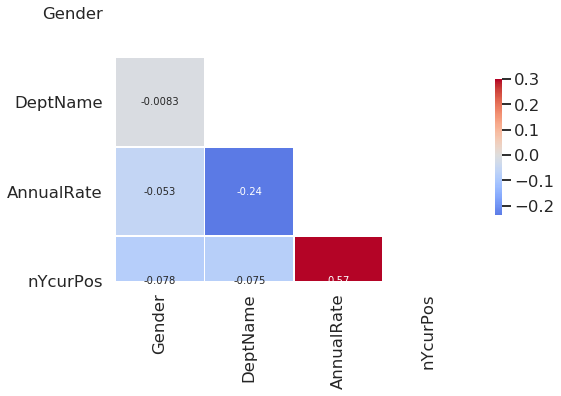

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))


# Compute the correlation matrix
corr = encoded_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#sns.heatmap(corr,vmax=.5, square=True,annot=True)
sns.heatmap(corr, mask=mask, vmax=.3, cmap='coolwarm',
            center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

Number of years at current position seems to have the biggest corelation 

In [15]:
# resetindex
encoded_df.reset_index(drop=True, inplace=True)
encoded_df.head(3)

,Gender,DeptName,AnnualRate,nYcurPos
0,1,1,77631.0,3.222517
1,0,10,95000.0,6.666804
2,0,9,77557.0,6.790009


First lets split up to fuatures and target columns. Then split 
the data into our training data (X_train), our testing data frame (X_test) and our target variables that we want to predict for both training and testing (y_train and y_test respectively).

In [16]:
#X= encoded_df.iloc[:,[0,1,3]].values 
#y= encoded_df.iloc[:,[2]].values #Annual rate  column is target
## Train_test split
#random_state = 42
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random_state)

In [17]:
X=encoded_df.drop(["AnnualRate"], axis=1)
y=encoded_df["AnnualRate"]
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
print("Shape train: %s, and test: %s" % (X_train.shape, X_test.shape))

Shape train: (562, 3), and test: (141, 3)


# check out  some default estimators

In [18]:
table = PrettyTable()
table.field_names = ["Model", "Datasetname", "MSE", "MAE","RMSE","R^2 score", "accuracy"]

def evaluate(xx,yy,dataset,model):
    y_pred = model.predict(xx)
    errors = abs(yy - y_pred)
    mse = mean_squared_error(yy,y_pred)
    mae = mean_absolute_error(yy,y_pred)
    rmse=np.sqrt(mse)
    r2score = model.score(xx, yy)
    mape = np.mean(100 * (errors/yy))#mean absolute percentage error (MAPE)
    accuracy = 100. - mape
    table.add_row([type(model).__name__, dataset, format(mse, '.2f'), format(mae, '.2f'),format(rmse, '.2f'), format(r2score, '.2f'),format(accuracy, '.2f')])
    

In [19]:
%%time
# Spot Check some Algorithms

models = [
    SGDRegressor(max_iter=1000, tol=1e-3),
    SVR(gamma='auto', kernel='linear'),
    SVR(gamma='auto', kernel='rbf'),
    BaggingRegressor(),
    RandomForestRegressor(random_state=42, n_estimators=50)
]

table.clear_rows() 
for model in models:
    model.fit(X_train, y_train) 
    evaluate(X_train, y_train,'training',model) #on the training set
print(table)
print("\n")
print("==== Let us evaluate the model on test set===")
table.clear_rows() 
for model in models:
    evaluate(X_test, y_test,'validation',model) #on the test/validation set  
print(table)


+-----------------------+-------------+--------------+----------+----------+-----------+----------+
|         Model         | Datasetname |     MSE      |   MAE    |   RMSE   | R^2 score | accuracy |
+-----------------------+-------------+--------------+----------+----------+-----------+----------+
|      SGDRegressor     |   training  | 158041918.39 | 10333.98 | 12571.47 |   -0.08   |  87.86   |
|          SVR          |   training  | 122806304.67 | 8532.08  | 11081.80 |    0.16   |  88.24   |
|          SVR          |   training  | 162472198.44 | 9863.68  | 12746.46 |   -0.11   |  86.34   |
|    BaggingRegressor   |   training  | 17670998.23  | 2760.75  | 4203.69  |    0.88   |  96.49   |
| RandomForestRegressor |   training  | 15292209.59  | 2720.10  | 3910.53  |    0.90   |  96.53   |
+-----------------------+-------------+--------------+----------+----------+-----------+----------+


==== Let us evaluate the model on test set===
+-----------------------+-------------+-------------

# Random Forest regressor

In [20]:
# Create the parameter grid based on the results of random search 
rf_hyper_params = {
    'bootstrap': [True],
    'max_depth': [4,6,8],
    'min_samples_split': [4,6,7,8],
    'n_estimators': [5,60,70,100],
   
}
random_state = 42
rfModel_hp = RandomForestRegressor(random_state=random_state)
# Instantiate the grid search model
rfModel_hp_GridSearch = GridSearchCV(rfModel_hp,param_grid=rf_hyper_params,cv = 3, n_jobs = -1, verbose = 2)
rfModel_hp_GridSearch.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    4.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [

In [21]:
#best parameters
means = rfModel_hp_GridSearch.cv_results_['mean_test_score']
stds = rfModel_hp_GridSearch.cv_results_['std_test_score']
params =rfModel_hp_GridSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f +- %f with: %r" % (mean, stdev, param))

print("\n")        
print("\t best parameters:", rfModel_hp_GridSearch.best_params_) 
print("\t best score:", rfModel_hp_GridSearch.best_score_) 
print("\n") 
rf_bestparams = {**rfModel_hp_GridSearch.best_params_}
print(rf_bestparams)

0.490263 +- 0.072973 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 5}
0.520628 +- 0.061604 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 60}
0.519044 +- 0.059564 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 70}
0.518213 +- 0.058387 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 100}
0.490277 +- 0.072771 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 5}
0.520562 +- 0.062558 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 60}
0.518976 +- 0.060597 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 70}
0.517957 +- 0.059222 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 100}
0.489275 +- 0.071712 with: {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 7, 'n_estimators': 5}
0.520401 +- 0.062699 with: {'bootstrap

In [22]:
#make the regressor with our tuned parameters
rfModel_GS_final = RandomForestRegressor(**rf_bestparams)

#fit
print("Fitting  RF model...")
rfModel_GS_final.fit(X_train, y_train)

#predict on Unseen data 
predict_rf_GS_final = rfModel_GS_final.predict(X_test)
#Metric: mean_squared_error 
#rmse = np.sqrt(mean_squared_error(y_test, predict_rf_GS_final))
#print("RMSE: %f" % (rmse))
#calculate_accuracy(y_test,predict_rf_GS_final)


Fitting  RF model...


In [23]:
table.clear_rows() 
evaluate(X_train, y_train,'training',rfModel_GS_final) #on the test/validation set  
print(table)

+-----------------------+-------------+-------------+---------+---------+-----------+----------+
|         Model         | Datasetname |     MSE     |   MAE   |   RMSE  | R^2 score | accuracy |
+-----------------------+-------------+-------------+---------+---------+-----------+----------+
| RandomForestRegressor |   training  | 42281722.97 | 4911.68 | 6502.44 |    0.71   |  93.66   |
+-----------------------+-------------+-------------+---------+---------+-----------+----------+


In [24]:
table.clear_rows() 
evaluate(X_test, y_test,'validation',rfModel_GS_final) #on the test/validation set  
print(table)

+-----------------------+-------------+-------------+---------+---------+-----------+----------+
|         Model         | Datasetname |     MSE     |   MAE   |   RMSE  | R^2 score | accuracy |
+-----------------------+-------------+-------------+---------+---------+-----------+----------+
| RandomForestRegressor |  validation | 68536808.57 | 6281.32 | 8278.70 |    0.50   |  91.91   |
+-----------------------+-------------+-------------+---------+---------+-----------+----------+


### Feature importance

In [25]:
features=list(X_test.columns.values)
features

['Gender', 'DeptName', 'nYcurPos']

In [26]:
importances = rfModel_hp_GridSearch.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfModel_hp_GridSearch.best_estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [27]:
## Print the feature ranking
print("Feature ranking:")
print(X_test.shape[1])
for f in range(X_test.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
3
1. feature nYcurPos (0.780405)
2. feature DeptName (0.202380)
3. feature Gender (0.017215)


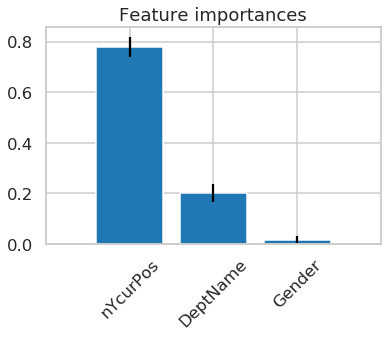

In [28]:
# Plot the feature importances of the random forest
#plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[i] for i in indices],rotation=45)
plt.xlim([-1, X_test.shape[1]])
plt.show()

# Make predictions with unseen test data

In [29]:
#create a new  fake test dataframe to check our final model
#basically a male and female working in dept 21 and dept 10 with varying number of years of experinece

raw_X_test = {'Gender': ['0', '1','0', '1','0', '1','0', '1'], 
        'DeptName': ['21','21','21','21', '10', '10', '10', '10'], 
        'nYcurPos': ['0.', '0.','10.', '10.','0.', '0.','10.', '10.' ], }
      
newToPredict_df = pd.DataFrame(raw_X_test, columns = ['Gender', 'DeptName', 'nYcurPos'])
#newToPredict_df 
newToPredict_xtest=newToPredict_df.as_matrix()
#newToPredict_xtest

In [30]:
y_hat=rfModel_GS_final.predict(newToPredict_xtest)
#y_hat = pd.DataFrame(y_hat, index=y_test1.index, columns=["calculated"])
#print(y_hat)
newToPredict_df["predictedAnnualRate"]=y_hat
newToPredict_df

,Gender,DeptName,nYcurPos,predictedAnnualRate
0,0,21,0.,72125.744363
1,1,21,0.,75102.800299
2,0,21,10.,93934.779282
3,1,21,10.,93980.843869
4,0,10,0.,70392.355714
5,1,10,0.,69158.084205
6,0,10,10.,93884.764626
7,1,10,10.,94004.954791
